## Bike Sharing Trends

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stat
import pylab
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



In [2]:
test_df=pd.read_csv('./test-3.csv')
original_dataset=pd.read_csv('./train-3.csv')
df=original_dataset.copy()

# Expolatory Data Analysis

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### There are no null values which is a good start

In [4]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

#### Segregating datetime for better insights and EDA

In [5]:
df['datetime']=pd.to_datetime(df['datetime'])


df['day']=df['datetime'].map(lambda x:x.day)
df['month']=df['datetime'].map(lambda x:x.month)
df['year']=df['datetime'].map(lambda x:x.year)
df['hour']=df['datetime'].map(lambda x:x.hour)

df.drop(labels=['datetime'], axis=1, inplace=True)

In [6]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,month,year,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,2011,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,2011,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2011,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,2011,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,2011,4


<AxesSubplot:xlabel='month', ylabel='count'>

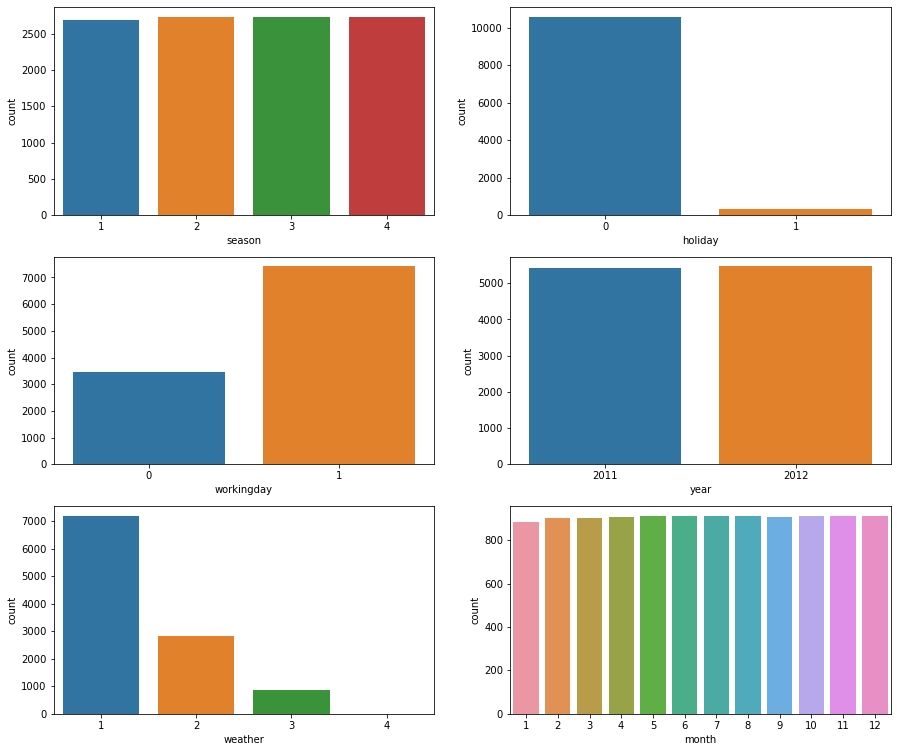

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(15, 13)

sns.countplot(x=df['season'], ax=axes[0][0])
sns.countplot(x=df['holiday'], ax=axes[0][1])
sns.countplot(x=df['workingday'], ax=axes[1][0])
sns.countplot(x=df['year'], ax=axes[1][1])
sns.countplot(x=df['weather'], ax=axes[2][0])
sns.countplot(x=df['month'], ax=axes[2][1])

We can clearly see that not all data is equally present for all the attributes such as -
1. Holiday
2. Working Day
3. Weather

<AxesSubplot:xlabel='weather', ylabel='count'>

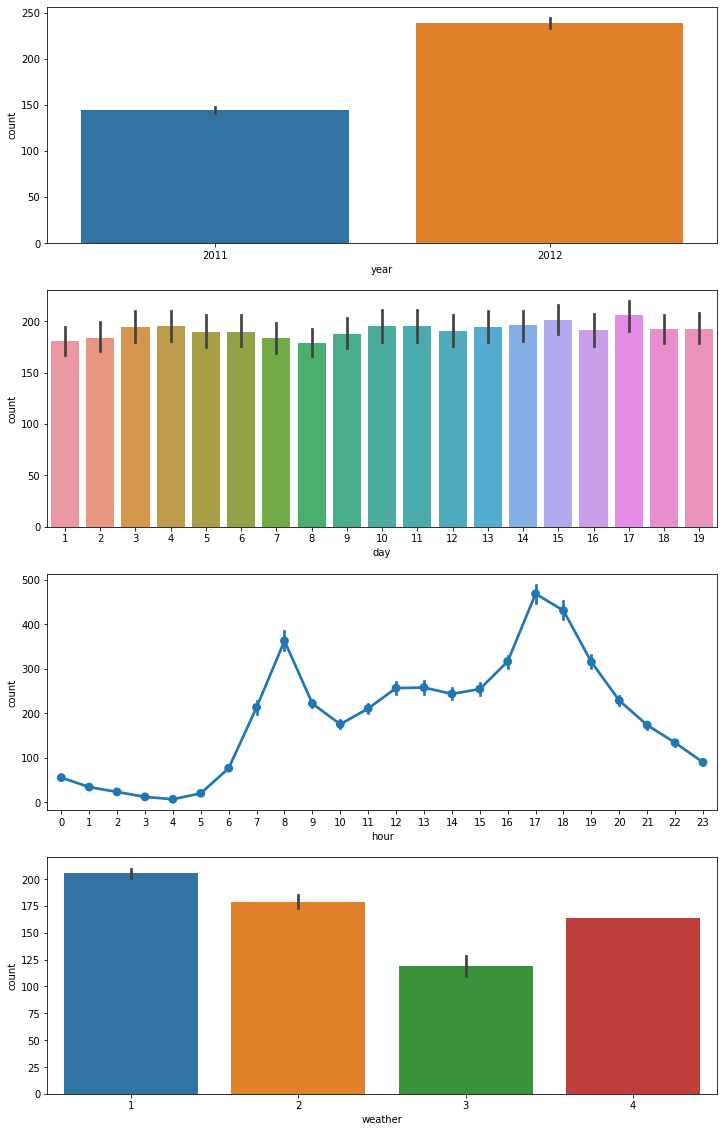

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig.set_size_inches(12, 20)

sns.barplot(x=df['year'], y=df['count'], ax=ax1)
sns.barplot(x=df['day'], y=df['count'], ax=ax2)
sns.pointplot(x=df['hour'], y=df['count'], ax=ax3)
sns.barplot(x=df['weather'], y=df['count'], ax=ax4)


- Twice the number of poeple opted for cycles in 2012 comapred to previous year.


- In morning 8:00 AM cycles are used as  means of commute to work and in  evening 5-6 PM people use cycle to have fun.

<AxesSubplot:xlabel='hour', ylabel='count'>

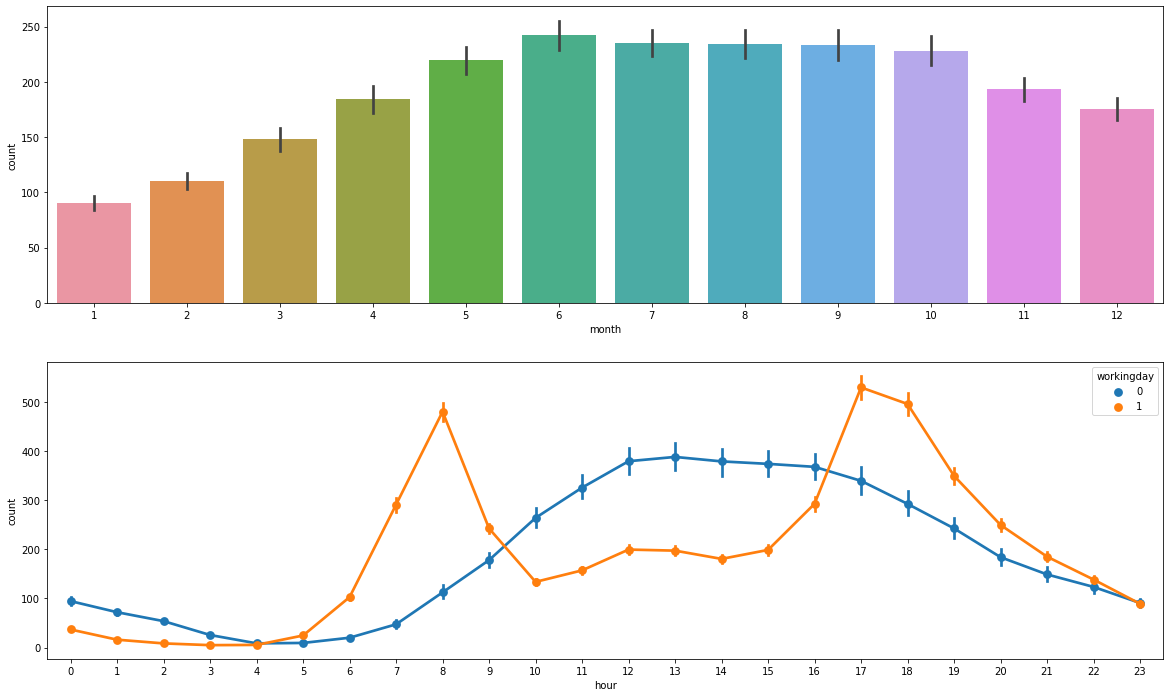

In [9]:
fig, (ax1,ax2) = plt.subplots(nrows=2)
fig.set_size_inches(20, 12)

sns.barplot(x=df['month'], y=df['count'],ax=ax1)
sns.pointplot(x=df['hour'], y=df['count'], hue=df['workingday'],ax=ax2)

- From January to May, it is quite cold in Washington DC, that is the reason very few people opt for cycles, but from june to october the weather is quite pleasent and that is when poeple opt for the cycles the most.

- On weekends cycles are used majority of the time from 11:00 AM to 4:00 PM, which makes sense, very few people would like to get up early in the morning to cycle around on weekend

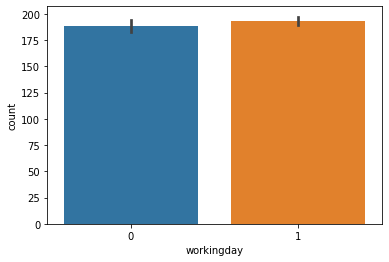

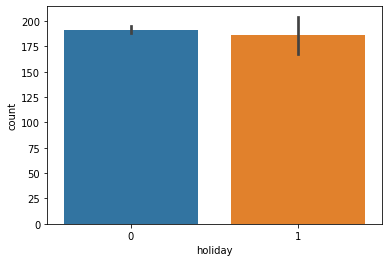

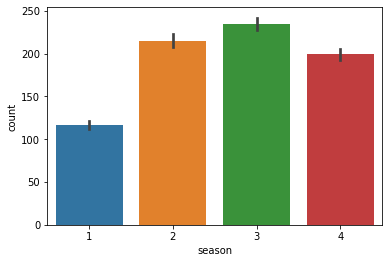

In [10]:

def Barplot(df, feature):
    sns.barplot(x=df[feature], y=df['count'])
    plt.show()


Barplot(df,'workingday')
Barplot(df, 'holiday')
Barplot(df,'season')


- Poeple use more cycles on weekends as compared to weekdays. As very few data is available for working and holiday, and still it is showing almost equivalent. Hence, more people use cycles on weekends and holidays

- Very few people on Spring use cycle which is strange, I wonder why :( 

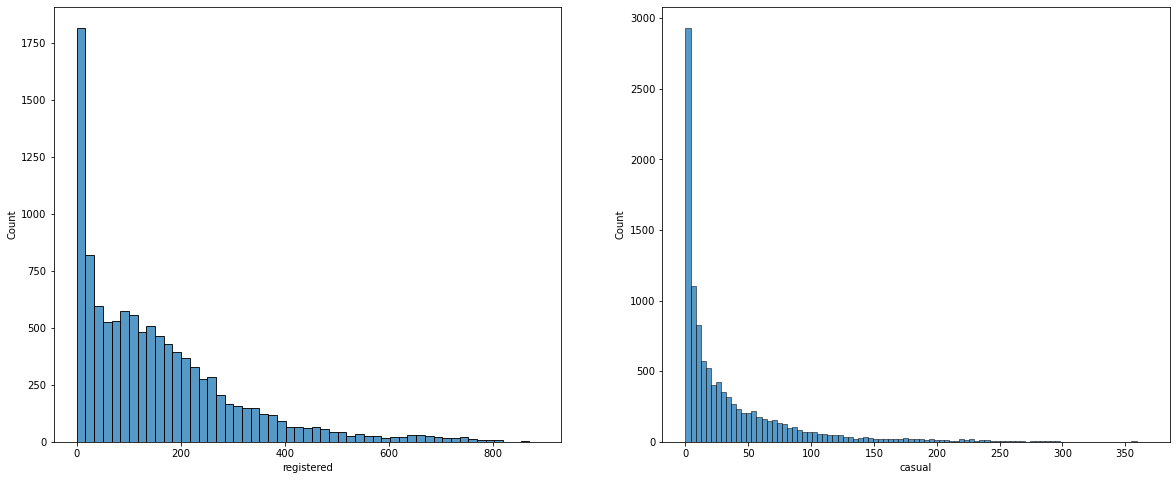

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(df['registered'], ax=ax1)
sns.histplot(df['casual'], ax=ax2)
plt.show()


- We can clearly see there were more registered users and the data is rightly skewed

# Feature Engineering

#### Using Q-Q plot to check which features are following Gausian Distribution


windspeed


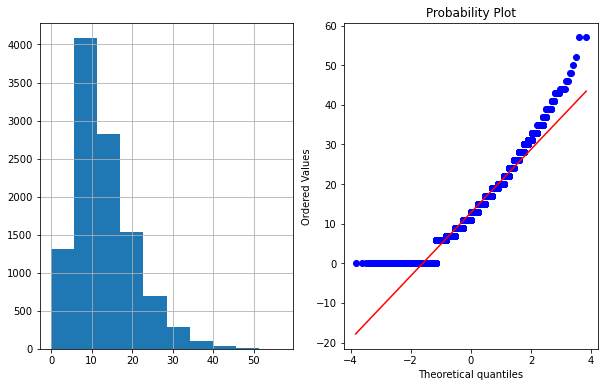

humidity


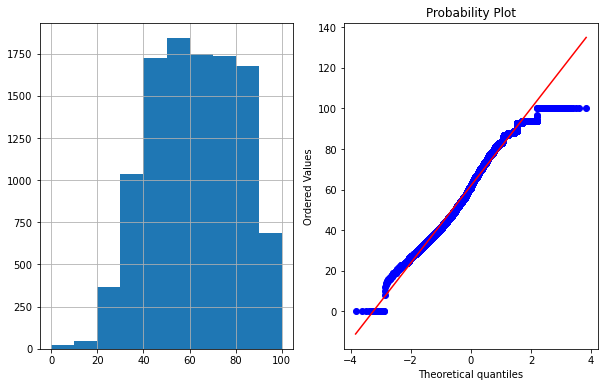

temp


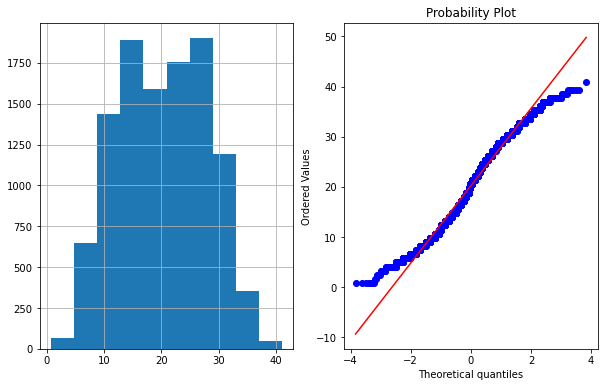

atemp


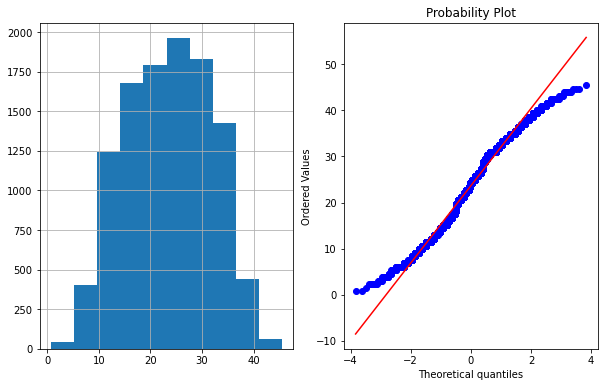

In [12]:
def plot_data(df, feature):
    # This is for the left graph
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    print(feature)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.show()


plot_data(df, 'windspeed')
plot_data(df, 'humidity')
plot_data(df, 'temp')
plot_data(df, 'atemp')

####  Fixing the right skewed data of registered,windspeed and casual with <br/>**BoxCox Transformation** <br/>as most of the ML Algos perform better with gausian distribution

casual


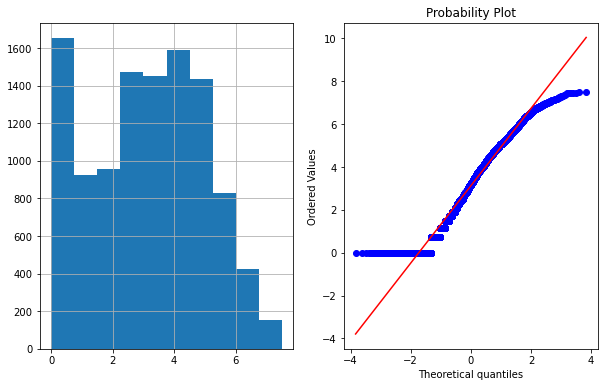

registered


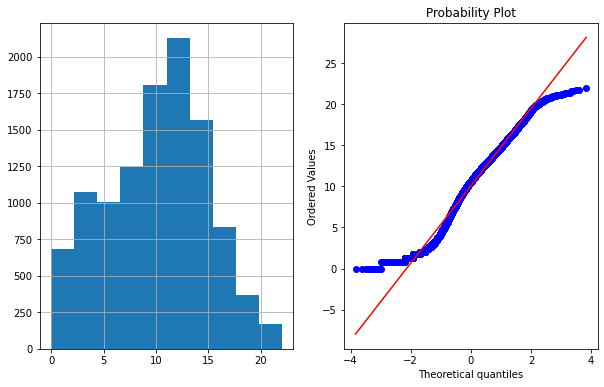

windspeed


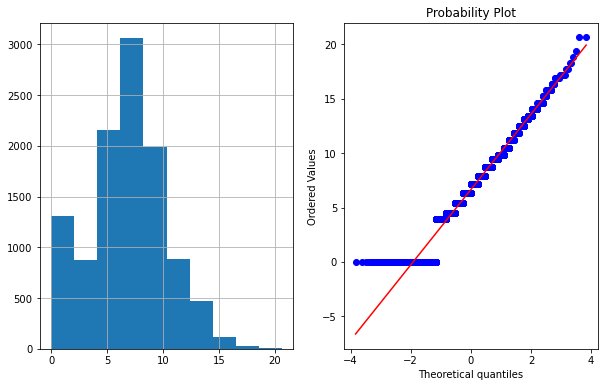

In [13]:
df['casual'],parameters=stat.boxcox(df['casual']+1)
plot_data(df,'casual')

df['registered'],parameters=stat.boxcox(df['registered']+1)
plot_data(df,'registered')

df['windspeed'],parameters=stat.boxcox(df['windspeed']+1)
plot_data(df,'windspeed')

#### Scaling the data with <br/> **Min-Max Scaler**

In [14]:
min_max=MinMaxScaler()
df_scaled=pd.DataFrame(min_max.fit_transform(df), columns=df.columns)

df_scaled.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,month,year,hour
0,0.0,0.0,0.0,0.0,0.224490,0.305068,0.81,0.0,0.195214,0.182347,0.015369,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.204082,0.288064,0.80,0.0,0.319544,0.279815,0.039959,0.0,0.0,0.0,0.043478
2,0.0,0.0,0.0,0.0,0.204082,0.288064,0.80,0.0,0.256400,0.259162,0.031762,0.0,0.0,0.0,0.086957
3,0.0,0.0,0.0,0.0,0.224490,0.305068,0.75,0.0,0.195214,0.159129,0.012295,0.0,0.0,0.0,0.130435
4,0.0,0.0,0.0,0.0,0.224490,0.305068,0.75,0.0,0.000000,0.034999,0.000000,0.0,0.0,0.0,0.173913


# Feature Selection

In [15]:
X = df.drop(labels=['count'], axis=1)
y = df['count']

y.head()

def kBest(number):
    ordered_rank_features = SelectKBest(score_func=chi2)
    ordered_feature = ordered_rank_features.fit(X, y)

    dfscores = pd.DataFrame(ordered_feature.scores_, columns=["Score"])
    dfcolumns = pd.DataFrame(X.columns)

    features_rank = pd.concat([dfcolumns, dfscores], axis=1)
    features_rank.columns = ['Features', 'Score']
    return features_rank.sort_values(by=['Score'], ascending=False).head(number)


kBest(20)


,Features,Score
9,registered,23962.821249
13,hour,18120.477372
6,humidity,12286.067545
8,casual,8800.794849
4,temp,8174.188620
5,atemp,8152.501468
10,day,2429.088872
11,month,2189.557845
7,windspeed,1880.994819
1,holiday,681.355480


In [16]:


corr_matrix = df.corr()

corr_matrix['count'].sort_values(ascending=False)


count         1.000000
registered    0.908014
casual        0.750732
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.105624
day           0.019826
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

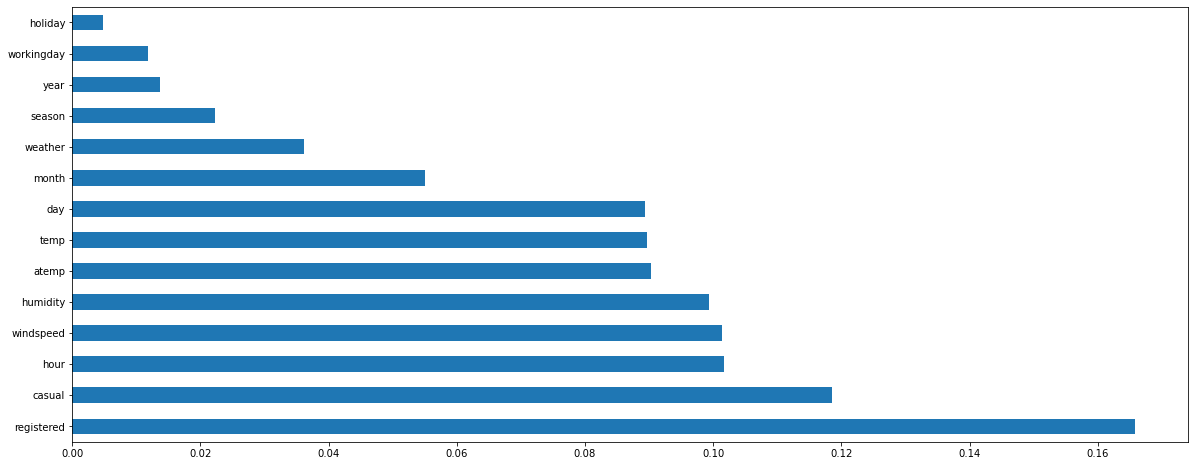

In [17]:
X = df.drop(labels=['count'], axis=1)
y = df['count']

y.head()

def ETC(number):
    model = ExtraTreesClassifier()
    model.fit(X, y)
    ranked_features = pd.Series(model.feature_importances_, index=X.columns)

    ranked_features.nlargest(number).plot(kind='barh', figsize=(20, 8))
    plt.show()


ETC(20)


- One of the important features while people are renting cycles are that is whether its windy, how is the temp to take out the cycle and is there humidity or not

<AxesSubplot:>

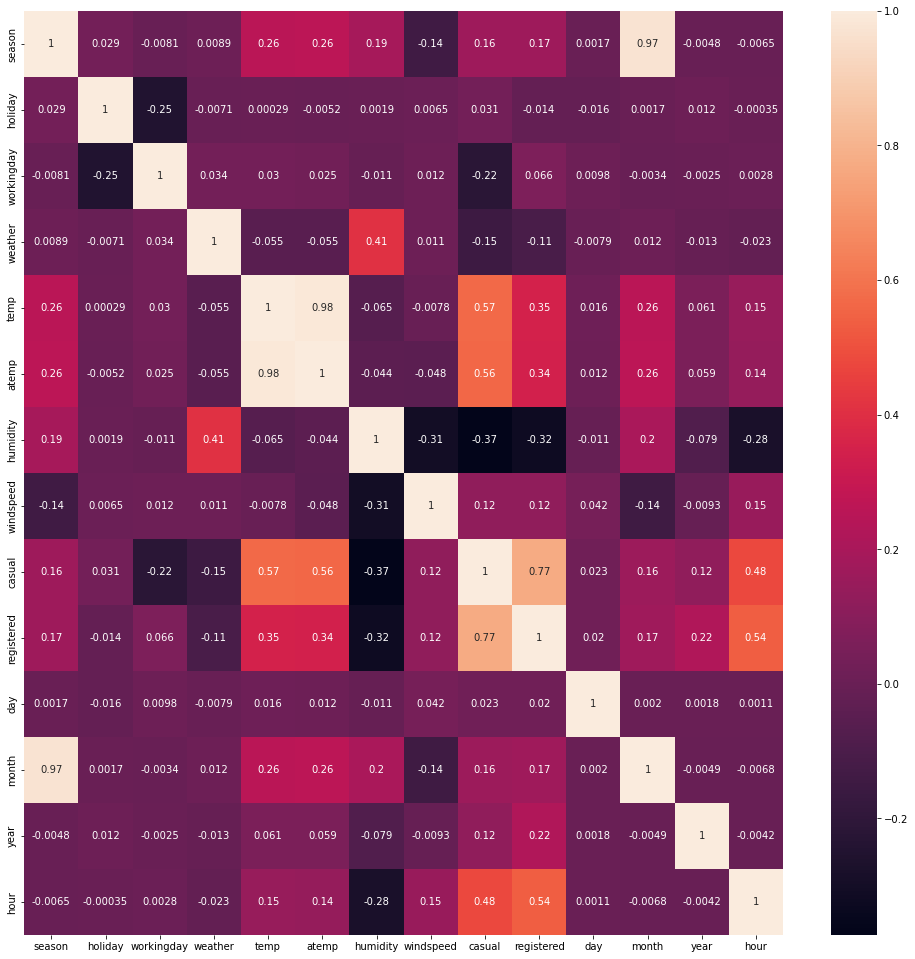

In [18]:
def correlationMap():

    corr = df.drop(labels=['count'], axis=1).corr()
    top_features = corr.index
    plt.figure(figsize=(17, 17))
    return sns.heatmap(df[top_features].corr(), annot=True)


correlationMap()


In [19]:
def correlation_2(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)

    return col_corr

correlation_2(df,0.8)

{'atemp', 'count', 'month'}

- As we can see that 'atemp' and 'month' are highly correlated feature, so dropping those columns

In [20]:
df_scaled.drop(labels=['atemp','month'], axis=1, inplace=True)

# Model Selection

In [21]:
# from sklearn import preprocessing
# from sklearn import utils

# lab = preprocessing.LabelEncoder()
# y_transformed = lab.fit_transform(y)

# y_transformed


In [22]:
X=df_scaled.drop(labels=['count'], axis=1)
y=df_scaled['count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=69)

X_train.shape, X_test.shape

((7620, 12), (3266, 12))

### Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [24]:
from sklearn.model_selection import cross_val_score

cv_scores=cross_val_score(rfr, X_train, y_train, cv=10)
print(cv_scores)
print()
print('Accuracy =',cv_scores.mean())

[0.99966447 0.99964797 0.99967174 0.99944795 0.99934053 0.99963643
 0.99978388 0.99957975 0.9996306  0.9996376 ]

Accuracy = 0.999604092413704


### Decision Tree Regressor

In [25]:
from sklearn.tree import DecisionTreeRegressor

dtr=DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [26]:
cv_scores=cross_val_score(dtr, X_train, y_train, cv=10)
print(cv_scores)
print()
print('Accuracy =',cv_scores.mean())

[0.99895082 0.99913629 0.99842215 0.99828484 0.99809896 0.99878801
 0.99903424 0.9981999  0.99864788 0.9985593 ]

Accuracy = 0.998612241338175


In [27]:
from sklearn.linear_model import Ridge
ridge=Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [28]:
cv_scores=cross_val_score(ridge, X_train, y_train, cv=10)
print(cv_scores)
print()
print('Accuracy =',cv_scores.mean())

[0.83706956 0.84470341 0.85983279 0.84650057 0.85065253 0.85469964
 0.85338225 0.84500558 0.85403074 0.83994676]

Accuracy = 0.8485823839132403


### Decision Tree Regressor is giving the best Accuracy
- Testing on the Test DataSet now

In [29]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_test, y_test)


DecisionTreeRegressor()

In [30]:
cv_scores=cross_val_score(dtr, X_test, y_test, cv=10)
print(cv_scores)
print()
print('Accuracy =',cv_scores.mean())

[0.99721558 0.99683991 0.99400251 0.99636232 0.99576379 0.99434331
 0.99704604 0.99678352 0.99808382 0.99776475]

Accuracy = 0.9964205546987737


/Users/kavach/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


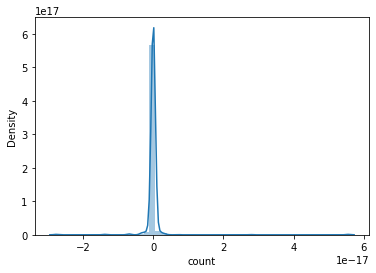

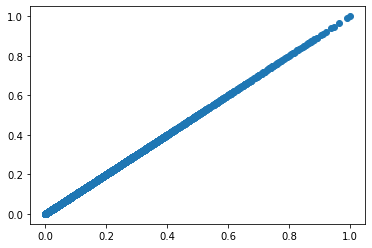

In [31]:
predictions=dtr.predict(X_test)
sns.distplot(y_test-predictions)
plt.show()
plt.scatter(y_test,predictions)

## Please let me know in the comments section, the mistakes I made and how can I improve more. 
## If you learned something from my work, please give it a Upvote.
## It would give me the dopamine rush :D